In [1]:
# This file provide template to download and work with the TinyImageNet dataset

In [2]:
# Please make sure GPU is disabled for this inference part of the lab
# Disable GPU and enable xla flags
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
import pathlib
import numpy as np
import tensorflow as tf
import os
import datetime
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Model

2021-11-01 16:21:11.368486: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
# Make sure that unzipped tiny-imagenet-200 folder is placed in the current directory
#define path to the dataset
path = pathlib.Path('/local/tiny-imagenet-200')

In [4]:
# Map the wnids to integer labels to words
with open(os.path.join(path, 'wnids.txt'), 'r') as f:
  wnids = [x.strip() for x in f]


# Map wnids to integer labels
wnid_to_label = {wnid: i for i, wnid in enumerate(wnids)}
label_to_wnid = {v: k for k, v in wnid_to_label.items()}

# Use words.txt to get names for each class
with open(os.path.join(path, 'words.txt'), 'r') as f:
  wnid_to_words = dict(line.split('\t') for line in f)
  for wnid, words in wnid_to_words.items():
      wnid_to_words[wnid] = [w.strip() for w in words.split(',')]
class_names = [wnid_to_words[wnid] for wnid in wnids]

In [5]:
# Import necessary packages
from __future__ import print_function
from builtins import range
from six.moves import cPickle as pickle
import numpy as np
import os
import platform
from tqdm import tqdm
import random
from imageio import imread
from imageio import imsave


# Function for loading the tiny imagenet data
def load_tiny_imagenet(path, is_training=True, dtype=np.float32, subtract_mean=True, debug=False, debug_nclass=3):
    """
    Load TinyImageNet. Each of TinyImageNet-100-A, TinyImageNet-100-B, and
    TinyImageNet-200 have the same directory structure, so this can be used
    to load any of them.

    Note: The original implementation loaded data as NCHW, I (tyler) changed it to NHWC

    Inputs:
    - path: String giving path to the directory to load.
    - is_training: If True, dont load testing data, if False, dont load training and val data
        Note: Must always load training data in order to subtract_mean.
    - dtype: numpy datatype used to load the data.
    - subtract_mean: Whether to subtract the mean training image.
    - debug: Whether or not to load a small number of classes for debugging

    Returns: A dictionary with the following entries:
    - class_names: A list where class_names[i] is a list of strings giving the
      WordNet names for class i in the loaded dataset.
    - X_train: (N_tr, 64, 64, 3) array of training images
    - y_train: (N_tr,) array of training labels
    - X_val: (N_val, 64, 64, 3) array of validation images
    - y_val: (N_val,) array of validation labels
    - X_test: (N_test, 64, 64, 3) array of testing images.
    - y_test: (N_test,) array of test labels; if test labels are not available
      (such as in student code) then y_test will be None.
    - mean_image: (64, 64, 3) array giving mean training image
    - label_to_wnid: dictionary with mapping from integer class label to wnid
    """
    # First load wnids
    with open(os.path.join(path, 'wnids.txt'), 'r') as f:
        wnids = [x.strip() for x in f]

    # Map wnids to integer labels
    wnid_to_label = {wnid: i for i, wnid in enumerate(wnids)}
    label_to_wnid = {v: k for k, v in wnid_to_label.items()}

    # Use words.txt to get names for each class
    with open(os.path.join(path, 'words.txt'), 'r') as f:
        wnid_to_words = dict(line.split('\t') for line in f)
        for wnid, words in wnid_to_words.items():
            wnid_to_words[wnid] = [w.strip() for w in words.split(',')]
    class_names = [wnid_to_words[wnid] for wnid in wnids]

    if debug:
        print('Debug is on! Only loading %d / %d training classes.'
                  % (debug_nclass, len(wnids)))

    # Next load training data.
    X_train, y_train = [], []
    train_wnids = wnids[:debug_nclass] if debug else wnids
    for i, wnid in tqdm(enumerate(train_wnids), total=len(train_wnids)):
        # To figure out the filenames we need to open the boxes file
        boxes_file = os.path.join(path, 'train', wnid, '%s_boxes.txt' % wnid)
        with open(boxes_file, 'r') as f:
            filenames = [x.split('\t')[0] for x in f]
        num_images = len(filenames)

        X_train_block = np.zeros((num_images, 64, 64, 3), dtype=dtype)
        y_train_block = wnid_to_label[wnid] * \
                        np.ones(num_images, dtype=np.int64)
        for j, img_file in enumerate(filenames):
            img_file = os.path.join(path, 'train', wnid, 'images', img_file)
            img = imread(img_file)
            if img.ndim == 2:   ## grayscale file
                img.shape = (64, 64, 1)
            X_train_block[j] = img
        X_train.append(X_train_block)
        y_train.append(y_train_block)

    # We need to concatenate all training data
    X_train = np.concatenate(X_train, axis=0)
    y_train = np.concatenate(y_train, axis=0)

    # Next load validation data
    X_val, y_val = None, None
    if is_training:
        print('loading validation data')
        with open(os.path.join(path, 'val', 'val_annotations.txt'), 'r') as f:
            img_files = []
            val_wnids = []
            for line in f:
                img_file, wnid = line.split('\t')[:2]
                img_files.append(img_file)
                val_wnids.append(wnid)
            num_val = len(img_files)
            y_val = np.array([wnid_to_label[wnid] for wnid in val_wnids])
            X_val = np.zeros((num_val, 64, 64, 3), dtype=dtype)
            for i, img_file in tqdm(enumerate(img_files), total=len(img_files)):
                img_file = os.path.join(path, 'val', 'images', img_file)
                img = imread(img_file)
                if img.ndim == 2:
                    img.shape = (64, 64, 1)
                X_val[i] = img

    mean_image = None
    if subtract_mean:
        mean_image = X_train.mean(axis=0)
        if is_training:
            X_train -= mean_image[None]
            X_val -= mean_image[None]
        else:
            X_test -= mean_image[None]

    if not is_training:
        X_train = None
        y_train = None
        

    return {
      'class_names': class_names,
      'X_train': X_train,
      'y_train': y_train,
      'X_val': X_val,
      'y_val': y_val,
      'mean_image': mean_image,
      'label_to_wnid': label_to_wnid
    }


In [6]:
print ("Loading Tiny-Imagenet Dataset for training and validation data")
dataset_train_val = load_tiny_imagenet(path, is_training = True, dtype=np.float32, subtract_mean=False)
x_val = dataset_train_val["X_val"] # 10000 images when each is a 64*64*3
y_val = dataset_train_val["y_val"] # 10000 elements
class_names = dataset_train_val["class_names"]
print(class_names)

Loading Tiny-Imagenet Dataset for training and validation data


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:02<00:00,  3.17it/s]


loading validation data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:06<00:00, 1437.34it/s]

[['Egyptian cat'], ['reel'], ['volleyball'], ['rocking chair', 'rocker'], ['lemon'], ['bullfrog', 'Rana catesbeiana'], ['basketball'], ['cliff', 'drop', 'drop-off'], ['espresso'], ['plunger', "plumber's helper"], ['parking meter'], ['German shepherd', 'German shepherd dog', 'German police dog', 'alsatian'], ['dining table', 'board'], ['monarch', 'monarch butterfly', 'milkweed butterfly', 'Danaus plexippus'], ['brown bear', 'bruin', 'Ursus arctos'], ['school bus'], ['pizza', 'pizza pie'], ['guinea pig', 'Cavia cobaya'], ['umbrella'], ['organ', 'pipe organ'], ['oboe', 'hautboy', 'hautbois'], ['maypole'], ['goldfish', 'Carassius auratus'], ['potpie'], ['hourglass'], ['seashore', 'coast', 'seacoast', 'sea-coast'], ['computer keyboard', 'keypad'], ['Arabian camel', 'dromedary', 'Camelus dromedarius'], ['ice cream', 'icecream'], ['nail'], ['space heater'], ['cardigan'], ['baboon'], ['snail'], ['coral reef'], ['albatross', 'mollymawk'], ['spider web', "spider's web"], ['sea cucumber', 'holoth

In [7]:
# Normalize all the float data between 0 and 1
x_val = x_val/255.0

In [8]:
# one hot encode y data
from tensorflow.keras.utils import to_categorical
num_classes = 200
y_val = to_categorical(y_val, num_classes)

['moving van']


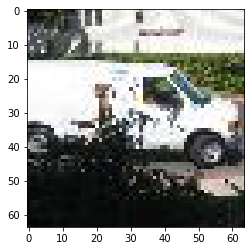

In [9]:
# E.g. visualization of one of the validation set image
import matplotlib.pyplot as plt
arr_ = np.squeeze(x_val[30]) # you can give axis attribute if you wanna squeeze in specific dimension

index = 0
for x in y_val[30]:
    if(x == 1):
        print(class_names[index])
        break
    index = index+1
plt.imshow(arr_)
plt.show()

In [10]:
# To do:  Load the H5 model and print summary. Please make sure the h5 model file is present in the current directory.
# Sample code to load the model
model = tf.keras.models.load_model('/local/jupyter/cpre482x-lab1/Inference/Template_Jupyter/CNN_tinyimagenet.h5', compile=False)

2021-11-01 16:22:29.314105: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-11-01 16:22:29.355063: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-11-01 16:22:29.355120: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: cpre482-10.ece.iastate.edu
2021-11-01 16:22:29.355131: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: cpre482-10.ece.iastate.edu
2021-11-01 16:22:29.357929: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.63.1
2021-11-01 16:22:29.357990: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.63.1
2021-11-01 16:22:29.357998: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.63.1
2021-11-01 16:22:29.367419: I 

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 60, 60, 32)        2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 56, 56, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 64)        3

In [12]:
# To do: Calculate Top-1, Top-5 accuracy on the validation set
# E.g. to calculate Top-10 accuracy
# Top-10 acc
acc_top10=0
acc_top5=0
acc_top1=0
for i in range(10000):
    t=x_val[i].reshape(1,64,64,3)
    y_pred= model.predict(t)
    y_true= np.argmax(y_val[i])
    S10=tf.math.top_k(y_pred, k=10, sorted=True, name=None)
    S5=tf.math.top_k(y_pred, k=5, sorted=True, name=None)
    S1=tf.math.top_k(y_pred, k=1, sorted=True, name=None)
    z10=(S10.indices.numpy())
    z5=(S5.indices.numpy())
    z1=(S1.indices.numpy())
    if(y_true in z10):
        acc_top10=acc_top10+1
    if(y_true in z5):
        acc_top5=acc_top5+1
    if(y_true in z1):
        acc_top1=acc_top1+1


2021-11-01 16:22:29.727228: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


In [13]:
print(acc_top10/10000)
print(acc_top5/10000)
print(acc_top1/10000)

0.6195
0.4965
0.242


['reel']
float32
(64, 64, 3)
393216
bits


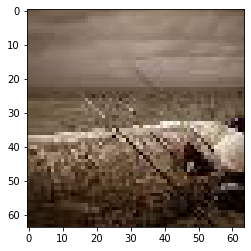

['refrigerator', 'icebox']
float32
(64, 64, 3)
393216
bits


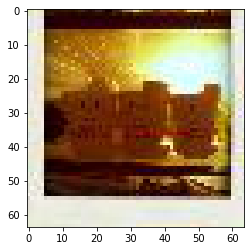

['bathtub', 'bathing tub', 'bath', 'tub']
float32
(64, 64, 3)
393216
bits


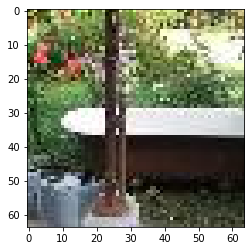

In [14]:
# To do: Print and visualize three inputs from the validation set. As an example, you may pick x_val[1], x_val[2] and x_val[3]
# To do: Print the data type
# To do: Print and note the dimensions of each image
# To do: Print the memory required to store each image 
import matplotlib.pyplot as plt
test1 = x_val[1]
test2 = x_val[2]
test3 = x_val[4]

arr1_ = np.squeeze(test1)
arr2_ = np.squeeze(test2)
arr3_ = np.squeeze(test3)

index1 = 0
for x in y_val[1]:
    if(x == 1):
        print(class_names[index1])
        break
    index1 = index1+1
    
print(arr1_.dtype)
print(arr1_.shape)
print(32*64*64*3)
print('bits')
    
plt.imshow(arr1_)
plt.show()
    
index2 = 0
for x in y_val[2]:
    if(x == 1):
        print(class_names[index2])
        break
    index2 = index2+1
    
print(arr2_.dtype)
print(arr2_.shape)
print(32*64*64*3)
print('bits')
    
plt.imshow(arr2_)
plt.show()
    
index3 = 0
for x in y_val[4]:
    if(x == 1):
        print(class_names[index3])
        break
    index3 = index3+1
    
print(arr3_.dtype)
print(arr3_.shape)
print(32*64*64*3)
print('bits')

plt.imshow(arr3_)
plt.show()


In [15]:
# To do:  Export each of the three inputs to a binary file which will be used to load later in a C program.
# Example code to export x_val[0] to a binary file:

# Load in a numpy array. # we flatten the array before exporting to binary file. So 64*64*3= 12288 elements 1d array
# NOTE *** So we must reshape before loading in a C program

# inp= np.asarray(x_val[0].flatten())

# # Save in a binary file i.e. numpy.ndarray.to_file()

# f_input=open("input.bin","wb")
# inp.tofile(f_input)
# f_input.close()

img1 = np.asarray(x_val[1].flatten())
img2 = np.asarray(x_val[2].flatten())
img3 = np.asarray(x_val[4].flatten())

f_input1 = open("img1.bin","wb")
f_input2 = open("img2.bin","wb")
f_input3 = open("img3.bin","wb")

img1.tofile(f_input1)
img2.tofile(f_input2)
img3.tofile(f_input3)

f_input1.close()
f_input2.close()
f_input3.close()


In [16]:
# To do: Print/Visualize weights of all the layers.
# To do: Print the data type
# To do: Print and note the dimensions of weights of each layer
# To do: Print the memory required to store the weights of each layer

for x in model.layers:
    print (x.weights)
    print("mem: ")
    print(5*5*3*32*32)


[<tf.Variable 'conv2d/kernel:0' shape=(5, 5, 3, 32) dtype=float32, numpy=
array([[[[-0.02122426,  0.00745977,  0.04947112, ...,  0.01030574,
          -0.00617077, -0.02055733],
         [-0.00364336, -0.09076936,  0.05811924, ...,  0.0752803 ,
          -0.07164451, -0.04541127],
         [-0.04846715, -0.06734135,  0.06361378, ..., -0.06857856,
          -0.08384255,  0.08390849]],

        [[ 0.03920702,  0.0694051 ,  0.03700081, ...,  0.04013554,
          -0.05361659, -0.07325943],
         [ 0.08876068, -0.02968463, -0.12168826, ..., -0.07692514,
          -0.02993259,  0.06455141],
         [ 0.07465422, -0.0738376 , -0.06305598, ..., -0.04973601,
          -0.10173006,  0.01413473]],

        [[ 0.03040346,  0.05223862,  0.09056094, ...,  0.08921412,
          -0.01309857,  0.06431119],
         [ 0.04301464,  0.02830401,  0.02891148, ..., -0.00523253,
           0.01857736, -0.0115426 ],
         [ 0.03589804, -0.08833345,  0.07426791, ..., -0.07683975,
           0.06587641, 

In [17]:
# To do:  (Similar to input ) Export all of the weights to a binary file which will be used to load later in a C program and use in the custom C/C++ inference implementation.

import re # for pattern matching

for j in range(3):
    # Saving for the convolution layers
    conv_index=1 # layer index starts from one
    for i in range(len(model.layers)):

        if re.match("conv", model.layers[i].name):
            layer_weights = np.asarray(model.layers[i].get_weights()) # Get all weights including biases
            layer_weights_flat=np.asarray(layer_weights[0].flatten()) # Get weights
            layer_biases_flat=np.asarray(layer_weights[1].flatten()) # Get biases
            
            # Save the weights as binary files in the folder of all three inputs
            f =open(os.path.abspath(os.getcwd()) + "/Test_Input"+str(j)+"/"+"conv"+str(conv_index)+"_weights.bin","wb")
            layer_weights_flat.tofile(f)
            f.close()
            
             # Save the biases as binary files in the folder of all three inputs
            f =open(os.path.abspath(os.getcwd()) + "/Test_Input"+str(j)+"/"+"conv"+str(conv_index)+"_biases.bin","wb")
            layer_biases_flat.tofile(f)
            f.close()
            
            conv_index=conv_index+1 # increment index
            
    # Saving for the dense layers       
    dense_index=1
    for i in range(len(model.layers)):

        if re.match("dense", model.layers[i].name):
            layer_weights = np.asarray(model.layers[i].get_weights()) # Get all weights including biases
            layer_weights_flat=np.asarray(layer_weights[0].flatten()) # Get weights
            layer_biases_flat=np.asarray(layer_weights[1].flatten()) # Get biases
            
            # Save the weights as binary files in the folder of all three inputs
            f =open(os.path.abspath(os.getcwd()) + "/Test_Input"+str(j)+"/"+"dense"+str(dense_index)+"_weights.bin","wb")
            layer_weights_flat.tofile(f)
            f.close()
            
             # Save the biases as binary files in the folder of all three inputs
            f =open(os.path.abspath(os.getcwd()) + "/Test_Input"+str(j)+"/"+"dense"+str(dense_index)+"_biases.bin","wb")
            layer_biases_flat.tofile(f)
            f.close()
            
            dense_index=dense_index+1 

/usr/local/anaconda3/envs/cpre482x_tf_gpu/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


FileNotFoundError: [Errno 2] No such file or directory: '/local/jupyter/cpre482x-lab1/Inference/Template_Jupyter/Test_Input0/conv1_weights.bin'

In [ ]:
# To do: Print/Visualize the intermediate feature maps for all of the layers for all three inputs.
# To do: Print the data type
# To do: Print and note the dimensions of intermediate feature maps of each layer
# To do: Print the memory required to store the intermediate feature maps of each layer

for i in range(len(model.layers)):
    layer = model.layers[i]
    print(type(layer), layer.name, layer.output.shape)



In [ ]:
# To do:  (Similar to input ) Export all of the intermediate feature maps for all three inputs to a binary file which will be used to load later in a C program and validate custom C/C++ inference implementation.

for j in range(3):
    
    for i in range(len(model.layers)):
        aux_model = tf.keras.Model(inputs=model.inputs,
                           outputs=[model.layers[i].output])
        
        # Store the intermediate output
        intermediate_layer_output = aux_model.predict(x_val[j].reshape(1,64,64,3))
        intermediate_layer_output_flat = np.asarray(intermediate_layer_output.flatten())

        # Save the Output in a binary file i.e. numpy.ndarray.to_file()
        f_output=open(os.path.abspath(os.getcwd()) + "/Test_Input"+str(j)+"/"+"layer_"+str(i)+"_output.bin","wb")
        intermediate_layer_output_flat.tofile(f_output)
        f_output.close()

In [ ]:
# Things for lab 2 after this comment

In [18]:
for i in range(len(model.layers)):
    layer = model.layers[i]
    print(type(layer), layer.name, layer.output.shape)

<class 'tensorflow.python.keras.layers.convolutional.Conv2D'> conv2d (None, 60, 60, 32)
<class 'tensorflow.python.keras.layers.convolutional.Conv2D'> conv2d_1 (None, 56, 56, 32)
<class 'tensorflow.python.keras.layers.pooling.MaxPooling2D'> max_pooling2d (None, 28, 28, 32)
<class 'tensorflow.python.keras.layers.convolutional.Conv2D'> conv2d_2 (None, 26, 26, 64)
<class 'tensorflow.python.keras.layers.convolutional.Conv2D'> conv2d_3 (None, 24, 24, 64)
<class 'tensorflow.python.keras.layers.pooling.MaxPooling2D'> max_pooling2d_1 (None, 12, 12, 64)
<class 'tensorflow.python.keras.layers.convolutional.Conv2D'> conv2d_4 (None, 10, 10, 64)
<class 'tensorflow.python.keras.layers.convolutional.Conv2D'> conv2d_5 (None, 8, 8, 128)
<class 'tensorflow.python.keras.layers.pooling.MaxPooling2D'> max_pooling2d_2 (None, 4, 4, 128)
<class 'tensorflow.python.keras.layers.core.Flatten'> flatten (None, 2048)
<class 'tensorflow.python.keras.layers.core.Dense'> dense (None, 256)
<class 'tensorflow.python.kera

In [31]:
# To do: Print and visualize three inputs from the validation set. As an example, you may pick x_val[1], x_val[2] and x_val[3]
# To do: Print the data type
# To do: Print and note the dimensions of each image
# To do: Print the memory required to store each image 
import matplotlib.pyplot as plt
test1 = x_val[1]
test2 = x_val[2]
test3 = x_val[4]

arr1_ = np.squeeze(test1)
arr2_ = np.squeeze(test2)
arr3_ = np.squeeze(test3)

def convolution_change_dtype():
    for i in range(len(model.layers)):
        layer = model.layers[i]
        print(type(layer), layer.name, layer.output.shape)
        print(layer.count_params)
    

index1 = 0
for x in y_val[1]:
    if(x == 1):
        print(class_names[index1])
        break
    index1 = index1+1
    
print(arr1_.dtype)
print(arr1_.shape)
print('Bits: ', 32*64*64*3)
   
print()
    
index2 = 0
for x in y_val[2]:
    if(x == 1):
        print(class_names[index2])
        break
    index2 = index2+1
    
print(arr2_.dtype)
print(arr2_.shape)
print('Bits: ', 32*64*64*3)
    
print()
    
index3 = 0
for x in y_val[4]:
    if(x == 1):
        print(class_names[index3])
        break
    index3 = index3+1
    
print(arr3_.dtype)
print(arr3_.shape)
print('Bits: ', 32*64*64*3)

convolution_change_dtype()

['reel']
float32
(64, 64, 3)
Bits:  393216

['refrigerator', 'icebox']
float32
(64, 64, 3)
Bits:  393216

['bathtub', 'bathing tub', 'bath', 'tub']
float32
(64, 64, 3)
Bits:  393216
<class 'tensorflow.python.keras.layers.convolutional.Conv2D'> conv2d (None, 60, 60, 32)
<bound method Layer.count_params of <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fd517e692e0>>
<class 'tensorflow.python.keras.layers.convolutional.Conv2D'> conv2d_1 (None, 56, 56, 32)
<bound method Layer.count_params of <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fd5155fa2e0>>
<class 'tensorflow.python.keras.layers.pooling.MaxPooling2D'> max_pooling2d (None, 28, 28, 32)
<bound method Layer.count_params of <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fd5180407f0>>
<class 'tensorflow.python.keras.layers.convolutional.Conv2D'> conv2d_2 (None, 26, 26, 64)
<bound method Layer.count_params of <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fd518